In [24]:
# Import system requirements
import sys, os

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pickle
import time

# Use NetworkX graphic package to create a signed network
import networkx as nx

# DWave Credentials
# dwave_solver = os.getenv('DWAVE_API_SOLVER')
dwave_solver = 'DW_2000Q_5'
api_key = os.getenv('DWAVE_API_TOKEN')

from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite

import dwave_networkx as dnx

# Select a D-Wave system and handle mapping from problem graph to sampler graph
sampler = EmbeddingComposite(DWaveSampler(solver=dwave_solver, token=api_key))

In [25]:
# Import data

dataset = 'sp100' # values: 'asset_class','ftse','sectors','sp100'

os.chdir("../data_modified")

with open("sp100_modules.txt", "rb") as fp:   # Unpickling
    myGraphs = pickle.load(fp)



In [26]:
# Helper Functions

def make_graph(corr_mat, node_labels, graph_type):

    G = nx.Graph()
    G.add_nodes_from(node_labels)
    dim = corr_mat.shape[0]

    if not dim == len(node_labels):
        raise ValueError('number node labels not = corr matrix dimensions')

    if graph_type=='signed':
        for i in range(dim):
            for j in range(i+1, dim):
                if corr_mat[i,j] < 0:
                    G.add_edge(node_labels[i], node_labels[j], sign=-1)
                elif corr_mat[i,j] > 0:
                    G.add_edge(node_labels[i], node_labels[j], sign=1)
    
    if graph_type=='corr':
        for i in range(dim):
            for j in range(i+1, dim):
                if corr_mat[i,j] != 0.000:
                    G.add_edge(node_labels[i], node_labels[j])
    
    if graph_type=='uncorr':
        for i in range(dim):
            for j in range(i+1, dim):
                if corr_mat[i,j] == 0.000:
                    G.add_edge(node_labels[i], node_labels[j])
    
    density = (2*G.number_of_edges())/(G.number_of_nodes()*(G.number_of_nodes() - 1))
                
    return G, density

def get_max_deg(G):
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)

    return max(degree_sequence)

def clique_size(clique):
    return len(clique)

In [27]:
# source code for DWave max clique algorithm - modified to include timing

from __future__ import division
import networkx as nx
import dwave_networkx as dnx
from dwave_networkx.utils import binary_quadratic_model_sampler


def maximum_clique(G, sampler=None, lagrange=2.0, **sampler_args):
  
    if G is None:
        raise ValueError("Expected NetworkX graph!")

    # finding the maximum clique in a graph is equivalent to finding
    # the independent set in the complementary graph
    complement_G = nx.complement(G)
    return maximum_independent_set(complement_G, sampler, lagrange, **sampler_args)


def clique_number(G, sampler=None, lagrange=2.0, **sampler_args):
    
    return len(maximum_clique(G, sampler, lagrange, **sampler_args))


def is_clique(G, clique_nodes):

    for x in clique_nodes:
        for y in clique_nodes:
            if x != y:
                if not(G.has_edge(x,y)):
                    return False
    return True


def maximum_weighted_independent_set(G, weight=None, sampler=None, lagrange=2.0, **sampler_args):

    # Get a QUBO representation of the problem
    Q = maximum_weighted_independent_set_qubo(G, weight, lagrange)

    # use the sampler to find low energy states
    response = sampler.sample_qubo(Q, **sampler_args) #this is where the optimization happens
    computation_time = response.info['timing']['qpu_access_time'] / 10**6 #compute qpu access time, and convert to seconds 
    # we want the lowest energy sample
    sample = next(iter(response))

    # nodes that are spin up or true are exactly the ones in S.
    return [node for node in sample if sample[node] > 0], computation_time


def maximum_independent_set(G, sampler=None, lagrange=2.0, **sampler_args):

    return maximum_weighted_independent_set(G, None, sampler, lagrange, **sampler_args)


def is_independent_set(G, indep_nodes):

    return len(G.subgraph(indep_nodes).edges) == 0


def maximum_weighted_independent_set_qubo(G, weight=None, lagrange=2.0):
    
    if not G:
        return {}

    cost = dict(G.nodes(data=weight, default=1))
    scale = max(cost.values())
    Q = {(node, node): min(-cost[node] / scale, 0.0) for node in G}
    Q.update({edge: lagrange for edge in G.edges})

    return Q


In [28]:
corr_mat_list = []
G_list = []
density_list = []
for myTuple in myGraphs:
    corr_tensor = myTuple[1]
    num_examples = corr_tensor.shape[0]
    nodes = myTuple[3]
    corr_mat = corr_tensor[int(num_examples/2), :, :].copy()
    corr_mat_list.append(corr_mat)
    corr_mat[(corr_mat > -1*0.3) & (corr_mat < 0.3)] = 0 #arbitrary threshold, for visualization purposes
    G_list.append(make_graph(corr_mat, nodes, 'corr')[0])
    density_list.append(make_graph(corr_mat, nodes, 'corr')[0])

In [29]:
import plotly.graph_objects as go

for G in G_list:
    pos = nx.spring_layout(G)
    nx.set_node_attributes(G, pos, 'pos')

    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = G.nodes[edge[0]]['pos']
        x1, y1 = G.nodes[edge[1]]['pos']
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')

    node_x = []
    node_y = []

    node_annotations = []

    for node in G.nodes():
        x, y = G.nodes[node]['pos']
        node_x.append(x)
        node_y.append(y)

        node_annotations.append(
            dict(text=node,
                 showarrow=False,
                 xref="x", yref="y",
                 x=x, y=y,
                font=dict(color='red', size=5)))



    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        marker=dict(
            showscale=True,
            # colorscale options
            #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
            #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
            #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
            colorscale='YlGnBu',
            reversescale=True,
            color=[],
            size=20,
            colorbar=dict(
                thickness=15,
                title='Node Connections',
                xanchor='left',
                titleside='right'
            ),
            line_width=2))

    node_adjacencies = []
    node_text = []

    for node, adjacencies in enumerate(G.adjacency()):
        node_adjacencies.append(len(adjacencies[1]))
        node_text.append('# of connections: '+str(len(adjacencies[1])))




    node_trace.marker.color = node_adjacencies
    node_trace.text = node_text



    fig = go.Figure(data=[edge_trace, node_trace],
                 layout=go.Layout(
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20,l=5,r=5,t=40),
                    annotations=node_annotations,
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                    )

    fig.show()

In [32]:
# Ensure DWave algorithm is working (just a test for one date)
max_clique_list = []
valid_soln_list = []
for G in G_list:
    max_clique_list.append(maximum_clique(G, sampler)[0])
    valid_soln_list.append(dnx.is_clique(G, max_clique))

    assert len(max_clique) > 0
    dnx.is_clique(G, max_clique)

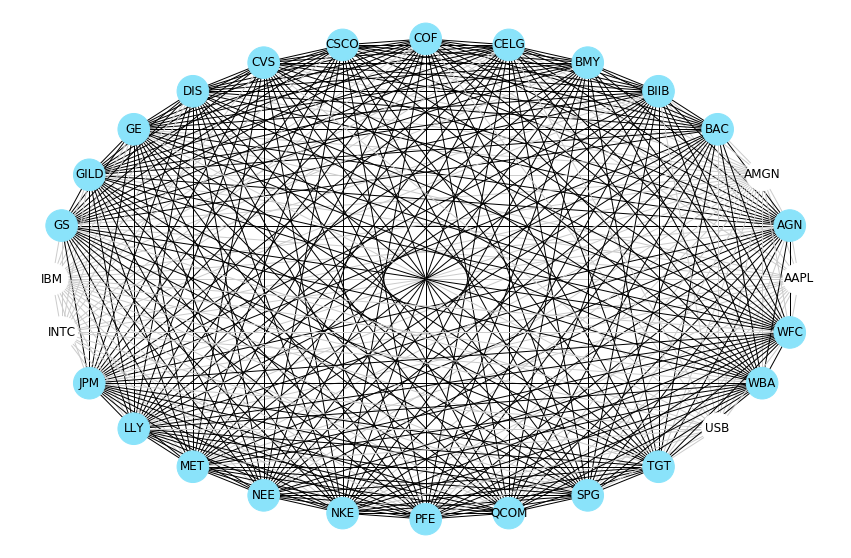

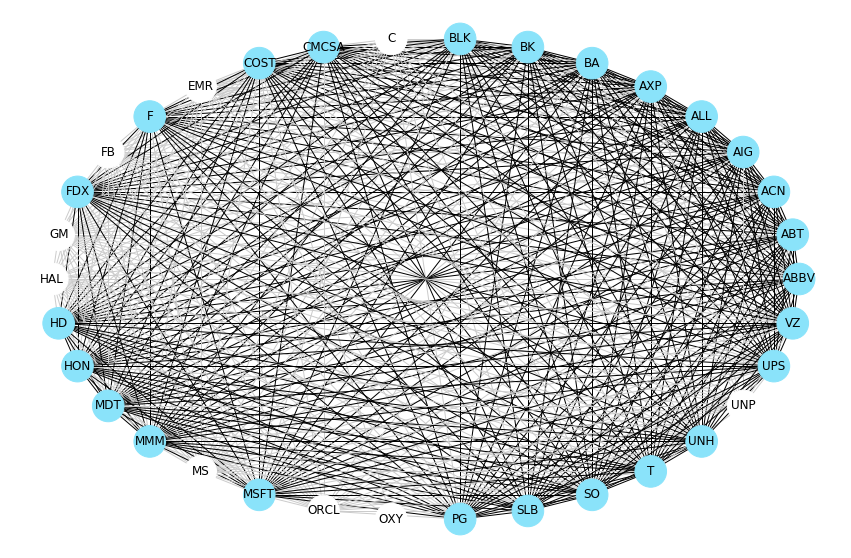

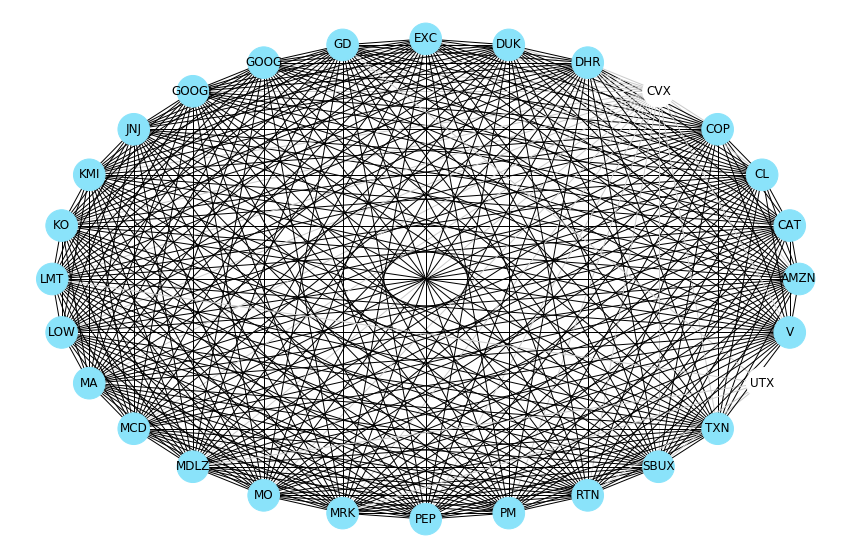

In [33]:
# # Draw solution
for i in range(len(G_list)):
    node_coloring = []
    for node in G_list[i].nodes():
        if node in max_clique_list[i]:
            node_coloring.append("#8ae3fa")
        else:
            node_coloring.append("white")

    edge_coloring = []

    for edge in G_list[i].edges():
        if edge[0] in max_clique_list[i] and edge[1] in max_clique_list[i]:
            edge_coloring.append("black")
        else:
            edge_coloring.append("#cccccc")

    fig,ax = plt.subplots(figsize=(15,10))
    nx.draw_shell(G_list[i], ax=ax, with_labels=True, node_size=1000,  node_color=node_coloring, edge_color=edge_coloring)

In [35]:

clique_array = []
valid_clique_array = []
clique_size_array = []
date_array = []
density_array = []
threshold_array = []
time_array = []


for i in range(len(myGraphs)):
    
    myTuple = myGraphs[i]
    
    corr_tensor = myTuple[1]
    num_examples = corr_tensor.shape[0]
    dates = myTuple[2]
    nodes = myTuple[3]
    
    count = 0 #count to keep track of progress when running
    for i in np.arange(0.1, 1, 0.1):
        for j in range(1, int(num_examples/5)): #division by 5 is just to speed up this for-loop, not necessary to have every month

            corr_mat = corr_tensor[j*5, :, :].copy()
            corr_mat[(corr_mat > -1*i) & (corr_mat < i)] = 0

            G, density = make_graph(corr_mat, nodes, 'corr')

            count += 1
            if count % 10 == 0: print("count: %d" % (count))

            try:
                opt_clique, comp_time = maximum_clique(G, sampler)
                max_clique_size = len(opt_clique)
                valid_clique = dnx.is_clique(G, opt_clique)

                for k in range(3): #try a few more times to increase likelihood of getting valid clique and good clique size
                    max_clique, comp_time_temp = maximum_clique(G, sampler)
                    clique_size = len(max_clique)
                    valid_clique = dnx.is_clique(G, max_clique)

                    if valid_clique and clique_size > max_clique_size:
                        opt_clique = max_clique
                        max_clique_size = clique_size
                        comp_time = comp_time_temp

            except Exception as err:
                print(err)
                print("No embedding found for threshold %f and matrix %d" % (i, j*5))
            else: 
                clique_array.append(opt_clique)
                valid_clique_array.append(valid_clique)
                clique_size_array.append(max_clique_size)
                time_array.append(comp_time)
                threshold_array.append(i)
                density_array.append(density)
                date_array.append(dates[j*5])

count: 10
count: 20
count: 30
count: 40
count: 50
count: 60
count: 10
count: 20
count: 30
count: 40
count: 50
count: 60
count: 10
count: 20
count: 30
count: 40
no embedding found
No embedding found for threshold 0.700000 and matrix 20
count: 50
count: 60
no embedding found
No embedding found for threshold 0.900000 and matrix 35


In [36]:
assert len(clique_array) == len(date_array) == len(density_array) == len(threshold_array) == len(clique_size_array) == len(time_array)

In [37]:
# Create Pandas DataFrame for quantum results
os.chdir("../result_files")

pd.DataFrame(data={"date": date_array, "threshold": threshold_array, "density": density_array,
                "max_clique": clique_array, "clique_size": clique_size_array, 
                "valid_clique": valid_clique_array, "computation_time": time_array}).to_csv("maxclique_quant_mod_%s_res.csv" % (dataset))

In [246]:
# Run classical max clique algm on the matrices that ran successfully above
from networkx.algorithms.approximation.clique import max_clique as class_max_clique

clique_array = []
valid_clique_array = []
clique_size_array = []
density_array = []
time_array = []

for i in range(len(threshold_array)):
    
    # get threshold and matrix idx 
    thresh = threshold_array[i]
    idx = dates.tolist().index(date_array[i])
    
    corr_mat = corr_tensor[idx, :, :].copy()
    corr_mat[(corr_mat > -1*thresh) & (corr_mat < thresh)] = 0

    G, density = make_graph(corr_mat, nodes, 'corr')

    try:
        t = time.clock()
        max_clique = class_max_clique(G)
        elapsed = time.clock() - t
        valid_clique = dnx.is_clique(G, max_clique)
    except Exception as err:
        print(err)
        print("Error on matrix %d with threshold %f" % (j*5, i))
    else:
        
        clique_array.append(max_clique)
        valid_clique_array.append(valid_clique)
        clique_size_array.append(len(max_clique))
        time_array.append(elapsed)
        density_array.append(density)

In [247]:
assert len(clique_array) == len(date_array) == len(density_array) == len(threshold_array) == len(clique_size_array) == len(time_array)

In [248]:
# Create Pandas DataFrame for class results
pd.DataFrame(data={"date": date_array, "threshold": threshold_array, "density": density_array,
                "max_clique": clique_array, "clique_size": clique_size_array, 
                "valid_clique": valid_clique_array, "computation_time": time_array}).to_csv("maxclique_class_%s_res.csv" % (dataset))

In [249]:
import neal
solver = neal.SimulatedAnnealingSampler()

def maximum_clique(G, sampler=None, lagrange=2.0, **sampler_args):
  
    if G is None:
        raise ValueError("Expected NetworkX graph!")

    # finding the maximum clique in a graph is equivalent to finding
    # the independent set in the complementary graph
    complement_G = nx.complement(G)
    return maximum_independent_set(complement_G, sampler, lagrange, **sampler_args)


def clique_number(G, sampler=None, lagrange=2.0, **sampler_args):
    
    return len(maximum_clique(G, sampler, lagrange, **sampler_args))


def is_clique(G, clique_nodes):

    for x in clique_nodes:
        for y in clique_nodes:
            if x != y:
                if not(G.has_edge(x,y)):
                    return False
    return True


def maximum_weighted_independent_set(G, weight=None, sampler=None, lagrange=2.0, **sampler_args):

    # Get a QUBO representation of the problem
    Q = maximum_weighted_independent_set_qubo(G, weight, lagrange)

    # use the sampler to find low energy states
    response = sampler.sample_qubo(Q, **sampler_args) #this is where the optimization happens
    # we want the lowest energy sample
    sample = next(iter(response))

    # nodes that are spin up or true are exactly the ones in S.
    return [node for node in sample if sample[node] > 0]


def maximum_independent_set(G, sampler=None, lagrange=2.0, **sampler_args):

    return maximum_weighted_independent_set(G, None, sampler, lagrange, **sampler_args)


def is_independent_set(G, indep_nodes):

    return len(G.subgraph(indep_nodes).edges) == 0


def maximum_weighted_independent_set_qubo(G, weight=None, lagrange=2.0):
    
    if not G:
        return {}

    cost = dict(G.nodes(data=weight, default=1))
    scale = max(cost.values())
    Q = {(node, node): min(-cost[node] / scale, 0.0) for node in G}
    Q.update({edge: lagrange for edge in G.edges})

    return Q


In [250]:
#SA 

clique_array = []
valid_clique_array = []
clique_size_array = []
density_array = []
time_array = []

for i in range(len(threshold_array)):
    
    # get threshold and matrix idx 
    thresh = threshold_array[i]
    idx = dates.tolist().index(date_array[i])
    
    corr_mat = corr_tensor[idx, :, :].copy()
    corr_mat[(corr_mat > -1*thresh) & (corr_mat < thresh)] = 0

    G, density = make_graph(corr_mat, nodes, 'corr')

    try:
        t = time.clock()
        max_clique = maximum_clique(G, sampler=solver, lagrange=2.0)
        elapsed = time.clock() - t
        valid_clique = dnx.is_clique(G, max_clique)
    except Exception as err:
        print(err)
        print("Error on matrix %d with threshold %f" % (j*5, i))
    else:
        
        clique_array.append(max_clique)
        valid_clique_array.append(valid_clique)
        clique_size_array.append(len(max_clique))
        time_array.append(elapsed)
        density_array.append(density)

In [251]:
# Create Pandas DataFrame for SA results
pd.DataFrame(data={"date": date_array, "threshold": threshold_array, "density": density_array,
                "max_clique": clique_array, "clique_size": clique_size_array, 
                "valid_clique": valid_clique_array, "computation_time": time_array}).to_csv("maxclique_SA_%s_res.csv" % (dataset))